In [26]:
# here we're going to just try writing something from scratch

In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# set up arrays
dx = 1000
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

Hstar = 0.5
etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(5, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x))
eta = etab + H

In [29]:
# set up parameters
K_ig = np.zeros(len(x))
K_ig[:14] = 1e-7
K_sed = np.zeros(len(x))
K_sed[14:] = 1e-6

beta_ig = np.zeros(len(x))
beta_ig[:14] = 4e-7
beta_sed = np.zeros(len(x))
beta_sed[14:] = 4e-6

# psi = np.zeros(len(x))
# psi[:14] = 4e-7
# psi[14:] = 4e-6
psi = 4e-7
gamma = 0.3

r = 10 # runoff rate
D = 0.015 # grain size
phi = 0.45 # porosity
baselevel_rate = 0.0001 # baselevel fall rate

In [30]:
kqs = 0.041
I = 0.01
kxb = 25
Pxb = 1./5.
kb = 8.3e-8

B_valley = kxb * (x_node**Pxb)
B_basin = (2./3.) * x_node

area = (1./3.) * x**2
# Q = r * x * B
Q = r * area

In [31]:
len(eta)

50

In [32]:
def model(x, dx, x_node,
          K_ig, K_sed, beta_ig, beta_sed,
          D, phi, Hstar, psi, gamma,
          kb, kqs, I, r, B_valley, B_basin, Q,
          etab, H, eta,
          baselevel_rate,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 0.2 * dx * dx / (kqs * q[-1]) # try changing to 10, 5, or 1 if this is unstable
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p_ig = np.zeros(len(x))
    Eb_p_sed = np.zeros(len(x))
    Eb_a_ig = np.zeros(len(x))
    Eb_a_sed = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= baselevel_rate * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc Rh
#         width = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
#         depth = (0.09801 * D) / S
#         Rh_efficiency = 1 - np.exp(-width/(2*depth))
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1]) # * Rh_efficiency
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p_ig[:-1] = K_ig[1:] * Q[1:] * S * alpha[:-1]
        Eb_p_sed[:-1] = K_sed[1:] * Q[1:] * S * alpha[:-1]
        Eb_a_ig[:-1] = beta_ig[1:] * Qs[1:] * alpha[:-1]
        Eb_a_sed[:-1] = beta_sed[1:] * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p_ig[:-1] + Eb_p_sed[:-1] + Eb_a_ig[:-1] + Eb_a_sed[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * psi
        
        # calc equilibrium lateral supply
        ql[1:14] = ((baselevel_rate * gamma) / psi) * (1 - np.exp(-psi/(3 * x[1:14])))
        ql[14:] = 0
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p_ig[:-1] - ql[1:])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p_ig, Eb_p_sed, Eb_a_ig, Eb_a_sed, Eb, atr, ql, Eh, E, etab, H, eta)

In [33]:
#now write a test
num_steps = 50000000
test_run = [x, dx, x_node, 
            K_ig, K_sed, beta_ig, beta_sed, 
            D, phi, Hstar, psi, gamma,
            kb, kqs, I, r, B_valley, B_basin, Q,
            etab, H, eta,
            baselevel_rate,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p_ig, Eb_p_sed, Eb_a_ig, Eb_a_sed, Eb, atr, ql, Eh, E, etab, H, eta) = model(*test_run)

6619211.935422632


In [34]:
E

array([9.99950990e-05, 9.99980034e-05, 9.99986215e-05, 9.99989230e-05,
       9.99991110e-05, 9.99992430e-05, 9.99993425e-05, 9.99994210e-05,
       9.99994851e-05, 9.99995386e-05, 9.99995841e-05, 9.99996237e-05,
       9.99996581e-05, 9.99996884e-05, 9.99997142e-05, 9.99997370e-05,
       9.99997573e-05, 9.99997761e-05, 9.99997924e-05, 9.99998075e-05,
       9.99998217e-05, 9.99998345e-05, 9.99998462e-05, 9.99998570e-05,
       9.99998671e-05, 9.99998767e-05, 9.99998859e-05, 9.99998939e-05,
       9.99999019e-05, 9.99999089e-05, 9.99999160e-05, 9.99999224e-05,
       9.99999289e-05, 9.99999347e-05, 9.99999400e-05, 9.99999454e-05,
       9.99999504e-05, 9.99999559e-05, 9.99999598e-05, 9.99999643e-05,
       9.99999685e-05, 9.99999725e-05, 9.99999771e-05, 9.99999802e-05,
       9.99999837e-05, 9.99999872e-05, 9.99999905e-05, 9.99999939e-05,
       9.99999973e-05, 1.00000000e-04])

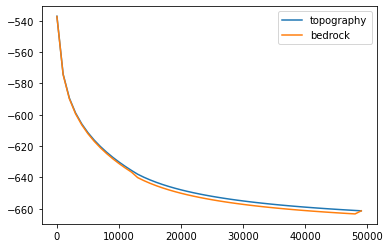

In [35]:
plt.plot(x, eta, label = "topography")
plt.plot(x, etab, label = "bedrock")
plt.legend()

In [36]:
# just for kicks
kb = 8.3e-8
b = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
print(b)

[ 3.21256916  4.56903163  5.94286696  7.38983416  8.90143247 10.46861222
 12.08435501 13.74326339 15.44109012 17.17440896 18.94039486 20.73667504
 22.56122543 20.09126877 20.08188492 20.07259638 20.06339258 20.05426465
 20.04520506 20.03620736 20.02726603 20.01837623 20.00953377 20.00073497
 19.99197659 19.98325573 19.97456985 19.96591664 19.95729406 19.94870025
 19.94013353 19.9315924  19.92307546 19.91458147 19.90610927 19.89765781
 19.88922611 19.8808133  19.87241853 19.86404106 19.85568017 19.84733521
 19.83900558 19.8306907  19.82239005 19.81410312 19.80582947 19.79756865
 19.78932025]


In [37]:
# ok really going out on a limb here...
depth = (0.09801 * D) / S
print(depth)

[0.03977585 0.09650556 0.15436949 0.209712   0.26210541 0.31177936
 0.3590739  0.40430873 0.44775655 0.48964358 0.53015661 0.56945043
 0.60765416 0.76206484 0.85808707 0.95885473 1.06428727 1.17431059
 1.28885627 1.40786083 1.53126514 1.65901398 1.79105558 1.9273413
 2.06782531 2.21246432 2.36121737 2.51404563 2.67091219 2.83178195
 2.99662145 3.16539875 3.33808334 3.51464602 3.69505878 3.87929481
 4.06732832 4.25913454 4.45468964 4.65397068 4.85695555 5.0636229
 5.27395216 5.48792343 5.7055175  5.92671577 6.15150024 6.37985348
 6.61175862]


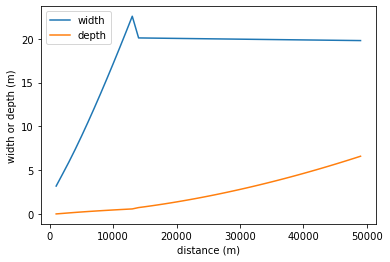

In [38]:
plt.plot(x[1:], b, label = 'width')
plt.plot(x[1:], depth, label = 'depth')
plt.ylabel('width or depth (m)')
plt.xlabel('distance (m)')
plt.legend()

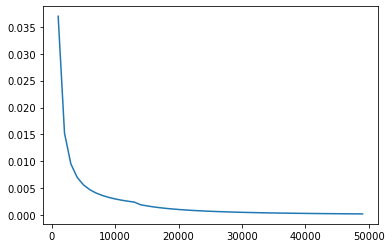

In [39]:
plt.plot(x[1:], S)

In [40]:
S

array([0.03696087, 0.01523384, 0.00952358, 0.00701033, 0.005609  ,
       0.00471535, 0.00409428, 0.00363621, 0.00328337, 0.00300249,
       0.00277305, 0.0025817 , 0.00241939, 0.00192917, 0.00171329,
       0.00153324, 0.00138135, 0.00125193, 0.00114066, 0.00104424,
       0.00096009, 0.00088616, 0.00082083, 0.00076279, 0.00071096,
       0.00066449, 0.00062262, 0.00058477, 0.00055043, 0.00051916,
       0.0004906 , 0.00046444, 0.00044042, 0.00041829, 0.00039787,
       0.00037897, 0.00036145, 0.00034518, 0.00033002, 0.00031589,
       0.00030269, 0.00029034, 0.00027876, 0.00026789, 0.00025767,
       0.00024805, 0.00023899, 0.00023044, 0.00022235])

In [41]:
ql

array([0.00000000e+00, 1.00000008e-08, 5.00000041e-09, 3.33333361e-09,
       2.50000021e-09, 2.00000017e-09, 1.66666680e-09, 1.42857393e-09,
       1.25000010e-09, 1.11111120e-09, 1.00000008e-09, 9.09089470e-10,
       8.33333402e-10, 7.69234676e-10, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [59]:
small_a_dist = 0.02 * x**(2)

In [60]:
small_a_dist

array([0.000e+00, 2.000e+04, 8.000e+04, 1.800e+05, 3.200e+05, 5.000e+05,
       7.200e+05, 9.800e+05, 1.280e+06, 1.620e+06, 2.000e+06, 2.420e+06,
       2.880e+06, 3.380e+06, 3.920e+06, 4.500e+06, 5.120e+06, 5.780e+06,
       6.480e+06, 7.220e+06, 8.000e+06, 8.820e+06, 9.680e+06, 1.058e+07,
       1.152e+07, 1.250e+07, 1.352e+07, 1.458e+07, 1.568e+07, 1.682e+07,
       1.800e+07, 1.922e+07, 2.048e+07, 2.178e+07, 2.312e+07, 2.450e+07,
       2.592e+07, 2.738e+07, 2.888e+07, 3.042e+07, 3.200e+07, 3.362e+07,
       3.528e+07, 3.698e+07, 3.872e+07, 4.050e+07, 4.232e+07, 4.418e+07,
       4.608e+07, 4.802e+07])

In [61]:
x

array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
       27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
       36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
       45000, 46000, 47000, 48000, 49000])

In [64]:
small_area = area[13]
small_a_array = np.linspace(0, small_area, len(x))
S_pred_array = ((baselevel_rate * gamma * small_a_array[1:])/(kqs * I * Q[1:]))**(6./7.)

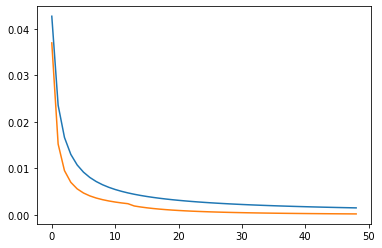

In [65]:
plt.plot(S_pred_array)
plt.plot(S)

In [44]:
S_pred_array

array([1.19963528, 0.36559295, 0.18244295, 0.1114157 , 0.07600024,
       0.05560011, 0.04268839, 0.03395431, 0.02774629, 0.02316133,
       0.01967001, 0.01694432, 0.01477175, 0.01300943, 0.01155827,
       0.01034769, 0.00932628, 0.00845578, 0.00770726, 0.00705849,
       0.00649214, 0.0059945 , 0.00555468, 0.00516384, 0.00481483,
       0.00450174, 0.00421971, 0.00396467, 0.0037332 , 0.00352242,
       0.00332988, 0.00315349, 0.00299146, 0.00284221, 0.00270443,
       0.00257693, 0.00245869, 0.00234881, 0.00224652, 0.0021511 ,
       0.00206194, 0.0019785 , 0.00190028, 0.00182685, 0.0017578 ,
       0.00169281, 0.00163153, 0.0015737 , 0.00151904])

In [45]:
difference = S_pred_array - S
print(difference)

[1.16267441 0.35035911 0.17291937 0.10440537 0.07039123 0.05088476
 0.0385941  0.03031811 0.02446292 0.02015884 0.01689696 0.01436262
 0.01235237 0.01108026 0.00984498 0.00881446 0.00794493 0.00720385
 0.0065666  0.00601425 0.00553205 0.00510834 0.00473385 0.00440105
 0.00410386 0.00383726 0.00359709 0.00337989 0.00318277 0.00300326
 0.00283928 0.00268905 0.00255104 0.00242392 0.00230656 0.00219795
 0.00209723 0.00200364 0.0019165  0.00183521 0.00175925 0.00168816
 0.00162152 0.00155896 0.00150013 0.00144475 0.00139254 0.00134326
 0.00129669]


In [51]:
area[13]

56333333.33333333

In [53]:
len(x)

50